# BOLD dynamics modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import wilcoxon

from dynamic_bias import utils
from dynamic_bias.analyses.fmri import HemodynamicModel
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/fmri")
vis_params = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/results_visual_drive.pickle')
vis_boot = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/bootstrap_visual_drive.pickle')
scores = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/results_correspondence_score.pickle')

downloading data/outputs/fmri...
data/outputs/fmri already exists. Skipping download...


---
## Visual beta parameters

In [3]:
hdt  = np.arange(4,28,step=2) # timing of interest
hdtv = np.arange(5,27,step=2)
hdm  = HemodynamicModel(onset_hemodynamic=hdt[0], visual_params=vis_params)

data_hdm = {'stim'  : np.array([0,0]),
            'ref'   : np.array([21.,21.]),
            't_dms' : np.array([6,12]),}

traj_b_pred = hdm.predict(data_hdm, model='visual')
m_traj, s_traj = utils.meanstats( hdm.interp(hdtv, hdt, vis_boot['traj']), sd=True, ci=True, axis=0 )

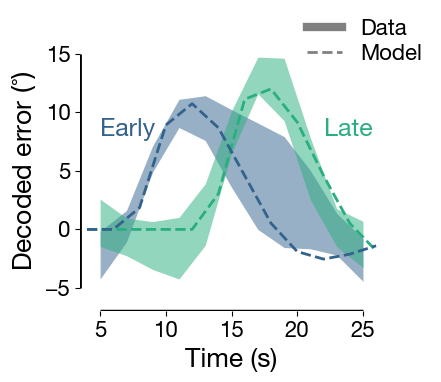

In [4]:
f,ax = plt.subplots(1,1,figsize=(4.5,4))

tt = np.arange(5,28,step=2)
plt.fill_between( hdtv, m_traj[0]-s_traj[0], m_traj[0]+s_traj[0], color=utils.E_COLOR, alpha=0.5, lw=0 )
plt.fill_between( hdtv, m_traj[1]-s_traj[1], m_traj[1]+s_traj[1], color=utils.L_COLOR, alpha=0.5, lw=0 )

plt.plot( hdt, traj_b_pred[1], color=utils.L_COLOR, linestyle='dashed', lw=2)
plt.plot( hdt, traj_b_pred[0], color=utils.E_COLOR, linestyle='dashed', lw=2)

plt.xlabel('Time (s)')
plt.ylabel(r"Decoded error $(\!\!^\circ\!\!)$")
plt.xlim([ 3.5,26.5])
plt.ylim([-7.0,17.0])

plt.text(5, 8, 'Early', color=utils.E_COLOR, fontsize=18)
plt.text(22,8, 'Late',  color=utils.L_COLOR, fontsize=18)

# legend
from matplotlib.legend_handler import HandlerTuple
marker_data  = {'markeredgewidth': 2, 'markersize': 9, 'linestyle': '-', 'linewidth': 6}
marker_model = {'markeredgewidth': 2, 'markersize': 9, 'linestyle': '--', 'linewidth': 2}
line_data  = mlines.Line2D([], [], color='gray', **marker_data)
line_model = mlines.Line2D([], [], color='gray', **marker_model)

plt.legend([line_data, line_model], ['Data', 'Model'],
           handler_map={tuple: HandlerTuple(ndivide=None)},
           frameon=False, loc=(0.72, 0.85), fontsize=16, 
           handletextpad=0.8, handlelength=1.6, labelspacing=0.22)

utils.draw_publish_axis(ax, xrange=[5,25], yrange=[-5,15], xticks=[5,10,15,20,25], yticks=[-5,0,5,10,15])
plt.savefig(f'{utils.DIR_FIGURE}/figs5a.pdf', bbox_inches='tight', transparent=True)
plt.show()

----
## Cosine scores

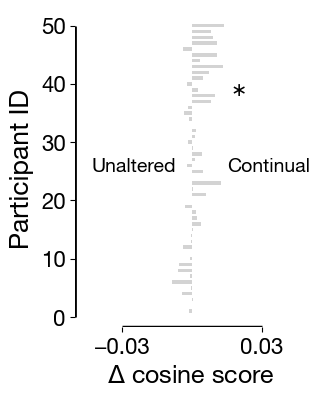

In [6]:
diff_cosines_score0 = np.subtract(
    [np.mean(v) for _,v in scores['full'].items()],
    [np.mean(v) for _,v in scores['reduced'].items()]
)

diff_cosines_score = np.subtract(
    [np.mean(v) for _,v in scores['full'].items()],
    [np.mean(v) for _,v in scores['full_encoding'].items()]
)

argsort = np.argsort(diff_cosines_score0)
plt.figure()
utils.set_size([2.4,3])
ax = plt.gca()

plt.barh(np.arange(1,51), (diff_cosines_score)[argsort], align='center', color='lightgray', height=0.6)
plt.xlim([-0.05,0.05])

plt.text(-0.043, 25, 'Unaltered', fontsize=14)
plt.text( 0.015, 25,  'Continual', fontsize=14)
plt.text(0.015, 38, r'$\,{\ast}$')

utils.draw_publish_axis(ax, xrange=(-0.03,0.03), yrange=(0,50), xticks=[-0.03,0.03], yticks=[0,10,20,30,40,50])

if utils.LABEL:
    kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
    plt.text( 0.28, -0.01, r'$\Delta$ cosine score', **kwargs)
    plt.ylabel(r'Participant ID')

plt.savefig(f'{utils.DIR_FIGURE}/figs5c.pdf',bbox_inches='tight', transparent=True)
plt.show()

In [7]:

ttest  = DescrStatsW(diff_cosines_score)
wilcox = wilcoxon(diff_cosines_score)
print('Paired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Paired samples t-test
t(49)= 2.482630855507196 p= 0.01651505651922409
95% CI= (0.00034763220543163097, 0.003301166799283155)
Wilcoxon signed-rank test (without continuity correction)
V= 459.0 p= 0.0857934137886982
